In [1]:
import torch

In [6]:
data = torch.load(r'dataset\12x12_m22\batch_0_l-594.pt')

all_grids, all_mines = data

In [7]:
grid_tensor = all_grids[0]
mines = all_mines[0]

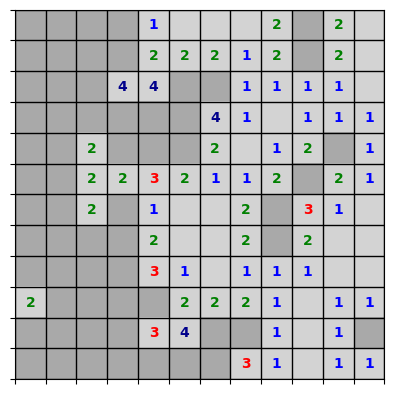

In [9]:
from models.Game_Tensor_Interface import Game_Tensor_Interface


Game_Tensor_Interface.view_grid_tensor(grid_tensor)
pass

In [18]:
from __future__ import annotations
from enum import Enum


# A box can be covered or not
# If the box is covered, it can be either known or unknown
# If it is known, it can be either a mine of a numer
Box_Knowledge = int
UNCOVERED = 0
UNKNOWN = 1
NUMBER = 2
MINE = 3

def is_covered(box: Box_Knowledge):
    return box > UNCOVERED

def is_known(box: Box_Knowledge):
    return box != UNKNOWN


In [16]:
from itertools import product
from numpy import ndarray
import numpy as np

Box = tuple[int, int]

class Grid_Knowledge:
    def __init__(
        self,
    ) -> None:
        super().__init__()
        self.to_inspect_1 : list[Box] = []
        self.to_inspect_2 : list[tuple[Box, Box]] = []
        self.knowledge: ndarray[Box_Knowledge] 

    def first_order_analysis(self):
        while len(self.to_inspect_1) > 0:
            x, y = self.to_inspect_1.pop(0)
            self.inspect_1(x, y)

    def second_order_analysis(self):
        while len(self.to_inspect_2) > 0:
            p1, p2 = self.to_inspect_2.pop(0)
            self.inspect_2(p1, p2)

            # Might need to inspect boxes
            self.first_order_analysis()

    def set_all_mines(self, *box_list: list[Box]):
        for x, y in box_list:
            self.set_mine(x, y)

    def set_mine(self, x: int, y: int):
        assert self.knowledge[x, y] != NUMBER
        if not is_known(self.knowledge[x, y]): # Avoid to reset as mine
            self.knowledge[x, y] = MINE
            self.to_inspect_1 += [
                n for n in self.all_neighbors(x, y) if self.uncovered_boxes[*n]
            ]
            # TODO : Propagate information for cross checking

    def set_all_numbers(self, *box_list: list[Box]):
        for x, y in box_list:
            self.set_number(x, y)
    
    def set_number(self, x: int, y: int):
        assert self.knowledge[x, y] != MINE
        if not is_known(self.knowledge[x, y]): # Avoid to reset as mine
            self.knowledge[x, y] = NUMBER
            self.to_inspect_1 += [
                n for n in self.all_neighbors(x, y) if self.uncovered_boxes[*n]
            ]
            # TODO : Propagate information for cross checking
            
    def action(self, grid: ndarray, grid_view: ndarray) -> tuple[int, int]:
        self.grid = grid
        self.uncovered_boxes = grid_view

        # Initialize our knowledge
        self.knowledge = np.ones(grid_view.shape, dtype=int)*UNKNOWN
        self.knowledge[grid_view] = UNCOVERED

        if np.all(~self.uncovered_boxes):
            # First action of the game
            # We cannot deduce any information
            return

        # One box rule on knowledge
        self.to_inspect_1 = list(np.argwhere(np.logical_and(grid_view, grid > 0)))
        self.first_order_analysis()

        # Two boxes rules of knowledge
        self.to_inspect_2 = list(
            np.argwhere(np.logical_and(grid_view, grid > 0))
        )  # TODO : Supress boxs without neighbours
        self.to_inspect_2 = [
            (p1, p2)
            for p1, p2 in product(self.to_inspect_2, self.to_inspect_2)
            if not np.all(p1 == p2)
        ]
        self.second_order_analysis()

    def all_neighbors(self, x: int, y: int):
        # List all neigbhors
        neighbors = [
            (x + dx, y + dy)
            for dx in (-1, 0, 1)
            for dy in (-1, 0, 1)
            if 0 <= x + dx
            and x + dx < self.knowledge.shape[0]
            and 0 <= y + dy
            and y + dy < self.knowledge.shape[1]
            and not (dx == 0 and dy == 0)
        ]
        return neighbors

    def inspect_1(self, x: int, y: int) -> tuple[int, int] | None:
        assert self.knowledge[x, y] == UNCOVERED
        value = self.grid[x, y]

        # Case value == 0 isn't interestng because all the neighbors are numbers
        if self.uncovered_boxes[x, y] and value > 0:
            neighbors = self.all_neighbors(x, y)
            unknown_boxes = [(i, j) for i, j in neighbors if self.knowledge[i, j] == UNKNOWN]

            n_unknown = len(unknown_boxes)
            n_mines = len([(i, j) for i, j in neighbors if self.knowledge[i, j] == MINE])

            n_hidden_mines = value - n_mines
            if n_hidden_mines == 0:
                # All unknown are numbers
                self.set_all_numbers(*neighbors)

            if n_hidden_mines == n_unknown:
                # All unknown are mines
                self.set_all_mines(*neighbors)

    def inspect_2(
        self, p1: tuple[float, float], p2: tuple[float, float]
    ) -> tuple[int, int] | None:
        if abs(p1[0] - p2[0]) > 2 or abs(p1[1] - p2[1]) > 2:
            # No intersection
            return
        
        # Values agregation
        c1 = self.grid[*p1] - len(
            [(i, j) for i, j in self.all_neighbors(*p1) if self.knowledge[i, j] == MINE] # TODO : HERE. See what need to change when we add the NUMBER state knowledge
        )  # Remove knowned mine count
        c2 = self.grid[*p2] - len(
            [(i, j) for i, j in self.all_neighbors(*p2) if self.knowledge[i, j] == MINE]
        )  # Remove knowned mine count
        v1 = [
            (i, j)
            for i, j in self.all_neighbors(*p1)
            if self.knowledge[i, j] == UNKNOWN
        ]
        v2 = [
            (i, j)
            for i, j in self.all_neighbors(*p2)
            if self.knowledge[i, j] == UNKNOWN
        ]
        vi = [p for p in v1 if p in v2]

        # Inverted condition for else as a return
        if c2 != c1 - len(v1) + len(vi):
            return None

        # v2\vi has no mines
        v2_outer = [p for p in v2 if p not in vi]
        if len(v2_outer) > 0:
            self.set_all_numbers(v2_outer)

        # T(v1\vi) = T(v1) - T(v2)
        # If T(v1\vi) == |v1\vi| -> Only mines
        v1_outer = [p for p in v1 if p not in vi]
        if c1 - c2 == len(v1_outer):
            # v1\vi is all mines
            self.set_all_mines(*v1_outer)



[tensor([[[[0, 0, 0,  ..., 0, 0, 1],
           [0, 0, 0,  ..., 0, 0, 1],
           [0, 0, 0,  ..., 0, 0, 1],
           ...,
           [0, 0, 0,  ..., 1, 0, 0],
           [0, 0, 0,  ..., 1, 0, 0],
           [0, 0, 0,  ..., 1, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 1, 1, 0],
           ...,
           [0, 0, 0,  ..., 0, 1, 1],
           [0, 0, 0,  ..., 0, 1, 0],
           [0, 0, 0,  ..., 0, 1, 1]],
 
          [[0, 0, 0,  ..., 0, 1, 0],
           [0, 0, 0,  ..., 0, 1, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [1, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0